# A Tutorial on Using MedImageInsight to Train an Adaptor for Chest Pathology Classification

MedImageInsight is a foundational model suited for a wide variety of medical image analysis tasks. In this tutorial, we will explore how to build a simple classifier for lung pathology classification by training an adapter on top of MedImageInsight embeddings. While MedImageInsight's out-of-the-box or zero-shot capabilities (similar to those explored in the [previous notebook](./zero-shot-classification.ipynb)) are powerful, they may not always be sufficient—especially for unseen pathology classes. By training an adapter, we can achieve superior performance compared to zero-shot classification, at the cost of training a new, but much simpler, classification model.

This approach leverages the embeddings generated by MedImageInsight and adds a simple classification layer to more effectively align pathology findings in chest X-rays. The new classification model is orders of magnitude simpler than training a model from scratch and can often be trained on a CPU.

This tutorial also explores methods to evaluate the performance of the classifier and provides visualizations.

## Prerequisites

This notebook requires the following setup. If you haven't completed these steps, please refer to the Getting Started section in the main README, which includes:

1. Deploying required models
2. Installing the Healthcare AI Toolkit
3. Downloading sample data
4. Configuring your `.env` file

### Required for This Notebook

- **Model Endpoint(s)**: `MI2_MODEL_ENDPOINT`
- **Additional Dependencies**: None

## Adapter Training Overview
In this tutorial, we will guide you through the process of using the embeddings generated by MedImageInsight to classify unseen chest pathologies in chest X-rays. We will demonstrate how to train an adapter model to improve classification performance. The steps we'll cover are:

1. **Load and Prepare Data and Model for Inference** 
    - We first setup our data and the MedImageInsight model for image embedding generation.

2. **Compute Embeddings**
    - We send the a small dataset (100 2D chest X-Ray dicoms) to MedImageInsight endpoint to obtain a set of embedding vectors corresponding to each image.

2. **Train Adapter Model using the Embeddings Generated by MedImageInsight**
    - We use the categorical labels from the small dataset as ground truth to improve detection capabilities in the following classes:
        1. **No Findings**
        2. **Support Devices**
        3. **Pleural Effusion**
        4. **Cardiomegaly**
        5. **Atelectasis**
    - We design the adapter network architecture and specify hyperparameters for the training process:
        - **Architecture:** We leverage [Multi-Layer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron) as the adapter architecture.
        - **Hyperparameters:** We specify hyperparameters such as batch size, optimizer, and learning rate for the training process.
        - **Training:** We perform adapter training to obtain a classifier capable of predicting the new pathology classes.
        - We only need to train the adaptor with small amount of time (**~15 seconds**) and limited resource (i.e. use CPU) to get a significant performance boost in adapting unseen categories of chest pathology!

3. **Evaluate Findings Classification Accuracy with Fine-Tuned Embeddings**
    - We perform inference to generate predictions using the adapter model we have just trained.
    - We directly predict categorical labels using MedImageInsight embeddings and the adapter MLP and compare to the ground-truth findings of each subject for evaluating accuracy

## 1. Setup and Imports

In [ ]:
## Load Packages for the tutorial
import pandas as pd
import torch
import os

from model_library.utils import training, inference
from model_library.embedding import AdapterModel
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from healthcareai_toolkit import settings
from healthcareai_toolkit.clients import MedImageInsightClient

# Suppress SimpleITK warnings
sitk.ProcessObject_SetGlobalWarningDisplay(False)

### Deploy Online Endpoint
Connect to MI2 Endpoint using our client.

In [ ]:
mi2_client = MedImageInsightClient()

INFO:azure.identity._credentials.environment:No environment configuration found.
INFO:azure.identity._credentials.managed_identity:ManagedIdentityCredential will use Azure ML managed identity
INFO:azure.identity._credentials.chained:DefaultAzureCredential acquired a token from ManagedIdentityCredential


Using ml_client base_url 1: https://management.azure.com
Using ml_client base_url 2: https://management.azure.com


### Input Data 

- **Data Composition per class:** 
    1. No Finding (20 Subjects)
    2. Support Devices (20 Subjects)
    3. Pleural Effusion (20 Subjects)
    4. Cardiomegaly (20 Subjects)
    5. Atelectasis (20 Subjects)
- **Computing Image Embeddings:** Our source images are in DICOM format, as typical for radiological images. During inference, we extract the image pixel bytes and convert them to 8-bit monochromatic bitmap for compatibility with MedImageInsight. We then compute image embeddings for each image using the MedImageInsight model.

**Diagnostic Labels**
- We provide the diagnostic information (i.e., Support Devices, Pleural Effusion) as categorical label (i.e. 0, 1, 2) to train an adaptor and enable the MedImageInsight embeddings to adapt on variable downstream tasks. The diagnostic labels are provided in the data split for training and testing: `<csv_folder>/adaptor_tutorial_train_split.csv` & `<csv_folder>/adaptor_tutorial_test_split.csv`.

In [ ]:
## Input Images and Text for Inference
data_root = settings.DATA_ROOT

if not os.path.exists(data_root):
    raise (
        Exception(
            f"Please download the files as described in this notebook into the data_root: {data_root}"
        )
    )

## Load image input folder for generating image embeddings
input_folder = os.path.join(data_root, "medimageinsight-classification", "images")
## Load csv folder labels and splits
csv_folder = os.path.join(data_root, "medimageinsight-classification", "csv")

## 2. Training Adaptor model with MedImageInsight Generated Embeddings
This section demonstrates how to leverage MedImageInsight image embeddings to train a new adapter model for downstream tasks with unseen label classes. The process is divided into two main steps:

- **2.1. Compute Embeddings**

    First, we split our dataset into training and testing sets. The splits are specified in the CSV files:
    - Training set: `<csv_folder>/adaptor_tutorial_train_split.csv`
    - Testing set: `<csv_folder>/adaptor_tutorial_test_split.csv`

    After splitting the data manually, we compute the image embeddings for all imaging samples in both sets using the MedImageInsight model. These embeddings are high-dimensional vectors that capture the semantic meaning of the visual content of the images. They serve as compact and informative representations for various downstream tasks.

- **2.2. Train the Adaptor Model with MedImageInsight Image Embeddings**

    After obtaining the image embeddings, we proceed to train the adapter model. We define the architecture of the adapter model, which is a 4-layer Multi-Layer Perceptron (MLP). This model is designed to efficiently adapt to the pathology labels that were not well represented in the original model training set.
    - Chest Pathology Labels: We focus on five pathology classes that contains the seen and unseen categories by the MedImageInsight model:
        1. **No Findings**
        2. **Support Devices**
        3. **Pleural Effusion**
        4. **Cardiomegaly**
        5. **Atelectasis**
    - Adapter Architecture and Training Parameters:
        - **Architecture:** The adapter is a 4-layer MLP that maps image embeddings to the new
        - **Hyperparameters:** 
            - **Optimizer:** AdamW
            - **Learning Rate:** 0.0005
            - **Batch Size:** 4

The adapter model is trained to map the MedImageInsight embeddings to these new categorical labels. We perform training and testing according to the data split and save the trained adapter model to `output_dir`.


##### 2.1 Compute Image Embeddings

In [ ]:
import glob

submitter = mi2_client.create_submitter(n_jobs=3)
image_files = list(glob.glob(input_folder + "/*.dcm"))
_, image_results = submitter.submit(image_list=image_files, total=len(image_files))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:49<00:00,  2.89s/it]


#### 2.2 Train the Adaptor Model with MedImageInsight Embeddings

**Loading Features into DataLoaders**

In this section, we prepare the precomputed image embeddings and labels for training and validation by creating respective DataLoaders for the downstream model training. 

1. First, we construct a DataFrame `df_features` that contains image names and their corresponding embeddings from image_embedding_dict.
2. Next, we load the training and validation data splits from CSV files (`adaptor_tutorial_train_split.csv` and `adaptor_tutorial_test_split.csv`) into DataFrames train_df and val_df. 
3. We merge these DataFrames with df_features on the 'Name' column to align the embeddings with their respective labels, resulting in train_merged and val_merged.
4. Finally, we create DataLoaders `train_ds` and `val_ds` using these dictionaries, specifying parameters like batch size and number of workers. These DataLoaders enable efficient batch processing of data during the training and validation of the adapter model.

In [ ]:
import numpy as np

print("----------Loading Features into DataLoader----------")
name_list = [os.path.basename(f) for f in image_files]
# Create a DataFrame for the features
df_features = pd.DataFrame(
    {
        "Name": name_list,
        "features": [np.array(v["image_features"][0]) for v in image_results],
    }
)

# Load the training and validation CSV files
train_csv_path = f"{csv_folder}/adaptor_tutorial_train_split.csv"
val_csv_path = f"{csv_folder}/adaptor_tutorial_test_split.csv"

# Read the CSV files into DataFrames
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Merge the DataFrames with the features DataFrame on 'Name'
train_merged = pd.merge(train_df, df_features, on="Name", how="inner")
val_merged = pd.merge(val_df, df_features, on="Name", how="inner")

# Prepare samples for the DataLoader
train_samples = {
    "features": train_merged["features"].tolist(),
    "img_name": train_merged["Name"].tolist(),
    "labels": train_merged["Label"].tolist(),  # Include labels if present
}
val_samples = {
    "features": val_merged["features"].tolist(),
    "img_name": val_merged["Name"].tolist(),
    "labels": val_merged["Label"].tolist(),  # Include labels if present
}

# Create the DataLoaders
train_ds = training.create_data_loader(
    train_samples,
    csv=train_merged,
    mode="train",
    batch_size=8,
    num_workers=2,
    pin_memory=True,
)
val_ds = training.create_data_loader(
    val_samples,
    csv=val_merged,
    mode="val",
    batch_size=1,
    num_workers=2,
    pin_memory=True,
)

print("----------Finished Loading Features into DataLoader!----------")

----------Loading Features into DataLoader----------
----------Finished Loading Features into DataLoader!----------


**Initializing Your Own Adaptor Model**

After successfully loading all image embeddings, we proceed to initialize the adapter model for chest pathology classification by setting several key parameters and components as follows:

1. The number of output classes (`num_class`): 5, matching the 5 chest pathology categories
2. The hidden layer dimension (`hidden_dim`): 512, providing a default model hidden dimension
3. The input channels (`in_channels`): 1024, matching to the MedImageInsight embedding dimension of 1024 to ensure compatibility. 
4. The learning rate (`learning_rate`): 0.0001
5. Loss Function (`loss_function_ts`): Cross-Entropy Loss
6. Optimizer (`optimizer`): AdamW

We then create the adaptor model and here we construct a multi-layer perceptron (MLP) with the above specifications. Finally, we define the output directory `output_dir` where the trained model and related outputs will be saved, ensuring the directory exists or is created if it doesn't.

In [ ]:
# Initialize the model, optimizer, and loss function
## Number of diagnostic label output classes
num_class = 5
## Hidden dimensions of the adaptor model feature
hidden_dim = 512
## MedImageInsight model embeddings dimensions: 1024,
in_channels = 1024  ## Matching the input channel of the adaptor model with the MedImageInsight embeddings channels
learning_rate = 0.0003

## Define the model, transforms, optimizer and loss function
model = AdapterModel(in_channels, hidden_dim, num_class)

print("Learning rate: {}".format(learning_rate))
loss_function_ts = torch.nn.CrossEntropyLoss()
print("Loss for training: {}".format("CrossEntropyLoss"))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print("Optimizer for training: {}".format(optimizer))

## Define Output Directory
output_dir = os.path.join("./medimageinsight_tutorial_output", "adaptor_model")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Learning rate: 0.0003
Loss for training: CrossEntropyLoss
Optimizer for training: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)


**Training the Adaptor Model**

In this section, we train the adapter model using the prepared training and validation DataLoaders. We only need to train such a small model with **~12 seconds** to have a performance boost in classificaiton accuracy. We set the maximum number of training epochs and initiate the training process:
- **Maximum Epochs** (max_epoch): We set the number of training epochs to 30, which determines how many times the model will iterate over the entire training dataset.

We then call the training function:
`training.trainer` Function: This function handles the training loop, validation, and performance tracking.
- Input Parameters: 
    1. `train_ds`: The DataLoader for the training dataset
    2. `val_ds`: The DataLoader for the validation dataset
    3. `model`: The adaptor model to be trained
    4. `loss_function_ts`: The loss function (`CrossEntrpyLoss`) used for optimization
    5. `optimizer`: The optimizer (`AdamW`) initialized earlier
    6. `epochs`: Number of Epochs to train the model (`max_epoch`)
    7. `root_dir`: Directory to save model checkpoints and logs (`output_dir`)

After training, the function returns the best accuracy `best_accuracy` and AUC `best_auc` (Area Under the Receiver Operating Characteristic Curve) achieved on the validation set. We then print these metrics, formatted to four decimal places, to summarize the model's performance. This step completes the training process and provides insight into how well the adapter model generalizes to unseen data.

In [ ]:
max_epoch = 30
best_accuracy, best_auc = training.trainer(
    train_ds,
    val_ds,
    model,
    loss_function_ts,
    optimizer,
    epochs=max_epoch,
    root_dir=output_dir,
)
print(f"Best Accuracy of the Adaptor: {best_accuracy:.4f}")
print(f"Best AUC of the Adaptor: {best_auc:.4f}")

----------
Epoch 1/30


1/10, train_loss: 1.6116
2/10, train_loss: 1.6916
3/10, train_loss: 1.6542
4/10, train_loss: 1.7346
5/10, train_loss: 1.6203
6/10, train_loss: 1.7313
7/10, train_loss: 1.5913
8/10, train_loss: 1.5841
9/10, train_loss: 1.6136
10/10, train_loss: 1.6148
Epoch 1 average loss: 1.6447


Saved new best metric model
Current epoch: 1 Current AUC: 0.9014 Current accuracy: 0.3500 Best AUC: 0.9014 Best accuracy: 0.3500 at epoch: 1
----------
Epoch 2/30


Train Epoch=1:  60%|█████████████████▍           | 6/10 [00:00<00:00, 27.19it/s]

1/10, train_loss: 1.5819
2/10, train_loss: 1.5732
3/10, train_loss: 1.5732
4/10, train_loss: 1.5606
5/10, train_loss: 1.5351
6/10, train_loss: 1.5464
7/10, train_loss: 1.5609
8/10, train_loss: 1.5162
9/10, train_loss: 1.4912
10/10, train_loss: 1.5168


Epoch 2 average loss: 1.5455


Current epoch: 2 Current AUC: 0.8935 Current accuracy: 0.4000 Best AUC: 0.9014 Best accuracy: 0.3500 at epoch: 1
----------
Epoch 3/30


Train Epoch=2:  10%|██▉                          | 1/10 [00:00<00:01,  7.67it/s]

1/10, train_loss: 1.3349


2/10, train_loss: 1.2235
3/10, train_loss: 1.4539
4/10, train_loss: 1.2682
5/10, train_loss: 1.5387
6/10, train_loss: 0.8438
7/10, train_loss: 1.2912
8/10, train_loss: 1.2465
9/10, train_loss: 0.9870
10/10, train_loss: 1.4416
Epoch 3 average loss: 1.2629


Current epoch: 3 Current AUC: 0.8924 Current accuracy: 0.6500 Best AUC: 0.9014 Best accuracy: 0.3500 at epoch: 1
----------
Epoch 4/30


Train Epoch=3:  10%|██▉                          | 1/10 [00:00<00:01,  8.06it/s]

1/10, train_loss: 0.5782


2/10, train_loss: 1.2278
3/10, train_loss: 0.6917
4/10, train_loss: 0.8696
5/10, train_loss: 0.6127
6/10, train_loss: 0.6376
7/10, train_loss: 1.3220
8/10, train_loss: 0.5164
9/10, train_loss: 0.2206
10/10, train_loss: 0.7948
Epoch 4 average loss: 0.7471


Current epoch: 4 Current AUC: 0.9000 Current accuracy: 0.5500 Best AUC: 0.9014 Best accuracy: 0.3500 at epoch: 1
----------
Epoch 5/30


Train Epoch=4:  10%|██▉                          | 1/10 [00:00<00:01,  7.36it/s]

1/10, train_loss: 0.2277


2/10, train_loss: 0.6726
3/10, train_loss: 1.0412
4/10, train_loss: 0.2359
5/10, train_loss: 0.5760
6/10, train_loss: 0.2894
7/10, train_loss: 0.1308
8/10, train_loss: 0.5677
9/10, train_loss: 0.3431
10/10, train_loss: 0.7276
Epoch 5 average loss: 0.4812


Saved new best metric model
Current epoch: 5 Current AUC: 0.9405 Current accuracy: 0.7000 Best AUC: 0.9405 Best accuracy: 0.7000 at epoch: 5
----------
Epoch 6/30


Train Epoch=5:  10%|██▉                          | 1/10 [00:00<00:01,  7.67it/s]

1/10, train_loss: 0.1287


Train Epoch=5:  60%|█████████████████▍           | 6/10 [00:00<00:00, 28.93it/s]

2/10, train_loss: 0.1953
3/10, train_loss: 0.3807
4/10, train_loss: 0.7853
5/10, train_loss: 0.1563
6/10, train_loss: 0.0651
7/10, train_loss: 0.2570
8/10, train_loss: 0.1435
9/10, train_loss: 0.1345
10/10, train_loss: 0.1796


Epoch 6 average loss: 0.2426


Current epoch: 6 Current AUC: 0.9213 Current accuracy: 0.7500 Best AUC: 0.9405 Best accuracy: 0.7000 at epoch: 5
----------
Epoch 7/30


Train Epoch=6:  10%|██▉                          | 1/10 [00:00<00:01,  7.45it/s]

1/10, train_loss: 0.0142


2/10, train_loss: 0.0300
3/10, train_loss: 0.0568
4/10, train_loss: 0.0316
5/10, train_loss: 0.0380
6/10, train_loss: 0.1259
7/10, train_loss: 0.0472
8/10, train_loss: 0.1973
9/10, train_loss: 0.0174
10/10, train_loss: 0.0891
Epoch 7 average loss: 0.0648


Saved new best metric model
Current epoch: 7 Current AUC: 0.9505 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 8/30


Train Epoch=7:  10%|██▉                          | 1/10 [00:00<00:01,  8.13it/s]

1/10, train_loss: 0.0173


2/10, train_loss: 0.0396
3/10, train_loss: 0.0064
4/10, train_loss: 0.4247
5/10, train_loss: 0.0064
6/10, train_loss: 0.0052
7/10, train_loss: 0.0203
8/10, train_loss: 0.0430
9/10, train_loss: 0.0143
10/10, train_loss: 0.3929
Epoch 8 average loss: 0.0970


Current epoch: 8 Current AUC: 0.9355 Current accuracy: 0.7500 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 9/30


Train Epoch=8:  10%|██▉                          | 1/10 [00:00<00:01,  7.87it/s]

1/10, train_loss: 0.2798


2/10, train_loss: 0.0051
3/10, train_loss: 0.0156
4/10, train_loss: 0.0013
5/10, train_loss: 0.0023
6/10, train_loss: 0.1577
7/10, train_loss: 0.0620
8/10, train_loss: 0.0075
9/10, train_loss: 0.3060
10/10, train_loss: 0.0068
Epoch 9 average loss: 0.0844


Current epoch: 9 Current AUC: 0.9376 Current accuracy: 0.7500 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 10/30


Train Epoch=9:  10%|██▉                          | 1/10 [00:00<00:01,  7.31it/s]

1/10, train_loss: 0.0154


2/10, train_loss: 0.7782
3/10, train_loss: 0.0065
4/10, train_loss: 0.0076
5/10, train_loss: 0.0141
6/10, train_loss: 0.0060
7/10, train_loss: 0.0147
8/10, train_loss: 0.0658
9/10, train_loss: 0.0044
10/10, train_loss: 0.0138
Epoch 10 average loss: 0.0927


Current epoch: 10 Current AUC: 0.8826 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 11/30


Train Epoch=10:  10%|██▊                         | 1/10 [00:00<00:01,  7.54it/s]

1/10, train_loss: 0.4574


Train Epoch=10:  70%|███████████████████▌        | 7/10 [00:00<00:00, 31.91it/s]

2/10, train_loss: 0.0186
3/10, train_loss: 0.0326
4/10, train_loss: 0.0851
5/10, train_loss: 0.0067
6/10, train_loss: 0.0033
7/10, train_loss: 0.0022
8/10, train_loss: 0.0043
9/10, train_loss: 0.1268
10/10, train_loss: 0.0352


Epoch 11 average loss: 0.0772


Current epoch: 11 Current AUC: 0.9286 Current accuracy: 0.8000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 12/30


Train Epoch=11:  10%|██▊                         | 1/10 [00:00<00:01,  7.52it/s]

1/10, train_loss: 0.0119


Train Epoch=11:  60%|████████████████▊           | 6/10 [00:00<00:00, 29.42it/s]

2/10, train_loss: 0.0108
3/10, train_loss: 0.0013
4/10, train_loss: 0.0126
5/10, train_loss: 0.0179
6/10, train_loss: 0.3547
7/10, train_loss: 0.0010
8/10, train_loss: 0.0227
9/10, train_loss: 0.1742
10/10, train_loss: 0.0038


Epoch 12 average loss: 0.0611


Current epoch: 12 Current AUC: 0.8663 Current accuracy: 0.6500 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 13/30


Train Epoch=12:  60%|████████████████▊           | 6/10 [00:00<00:00, 26.07it/s]

1/10, train_loss: 0.0198
2/10, train_loss: 0.0019
3/10, train_loss: 0.0094
4/10, train_loss: 0.0402
5/10, train_loss: 0.7982
6/10, train_loss: 0.0009
7/10, train_loss: 0.0275
8/10, train_loss: 0.1300
9/10, train_loss: 0.0013
10/10, train_loss: 0.0031


Epoch 13 average loss: 0.1032


Current epoch: 13 Current AUC: 0.8984 Current accuracy: 0.7500 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 14/30


Train Epoch=13:  10%|██▊                         | 1/10 [00:00<00:01,  7.52it/s]

1/10, train_loss: 0.0035


2/10, train_loss: 0.0089
3/10, train_loss: 0.0088
4/10, train_loss: 0.0016
5/10, train_loss: 0.1529
6/10, train_loss: 0.0114
7/10, train_loss: 0.0066
8/10, train_loss: 0.0303
9/10, train_loss: 0.0059
10/10, train_loss: 0.0027
Epoch 14 average loss: 0.0232


Current epoch: 14 Current AUC: 0.9389 Current accuracy: 0.7500 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 15/30


Train Epoch=14:  10%|██▊                         | 1/10 [00:00<00:01,  7.72it/s]

1/10, train_loss: 0.0020


2/10, train_loss: 0.0011
3/10, train_loss: 0.0012
4/10, train_loss: 0.0036
5/10, train_loss: 0.0016
6/10, train_loss: 0.0032
7/10, train_loss: 0.0074
8/10, train_loss: 0.0077
9/10, train_loss: 0.0036
10/10, train_loss: 0.0090
Epoch 15 average loss: 0.0041


Current epoch: 15 Current AUC: 0.9439 Current accuracy: 0.7500 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 16/30


Train Epoch=15:  10%|██▊                         | 1/10 [00:00<00:01,  7.49it/s]

1/10, train_loss: 0.0013


Train Epoch=15:  60%|████████████████▊           | 6/10 [00:00<00:00, 27.91it/s]

2/10, train_loss: 0.0057
3/10, train_loss: 0.0029
4/10, train_loss: 0.0048
5/10, train_loss: 0.0012
6/10, train_loss: 0.0011
7/10, train_loss: 0.0010
8/10, train_loss: 0.0052
9/10, train_loss: 0.0018
10/10, train_loss: 0.0004


Epoch 16 average loss: 0.0026


Current epoch: 16 Current AUC: 0.9309 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 17/30


Train Epoch=16:  10%|██▊                         | 1/10 [00:00<00:01,  7.94it/s]

1/10, train_loss: 0.0028


Train Epoch=16:  70%|███████████████████▌        | 7/10 [00:00<00:00, 32.49it/s]

2/10, train_loss: 0.0013
3/10, train_loss: 0.0009
4/10, train_loss: 0.0033
5/10, train_loss: 0.0031
6/10, train_loss: 0.0004
7/10, train_loss: 0.0028
8/10, train_loss: 0.0008
9/10, train_loss: 0.0012
10/10, train_loss: 0.0010


Epoch 17 average loss: 0.0018


Current epoch: 17 Current AUC: 0.9259 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 18/30


Train Epoch=17:  60%|████████████████▊           | 6/10 [00:00<00:00, 25.55it/s]

1/10, train_loss: 0.0025
2/10, train_loss: 0.0010
3/10, train_loss: 0.0007
4/10, train_loss: 0.0003
5/10, train_loss: 0.0021
6/10, train_loss: 0.0009
7/10, train_loss: 0.0008
8/10, train_loss: 0.0024
9/10, train_loss: 0.0005
10/10, train_loss: 0.0008


Epoch 18 average loss: 0.0012


Current epoch: 18 Current AUC: 0.9235 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 19/30


Train Epoch=18:  10%|██▊                         | 1/10 [00:00<00:01,  7.62it/s]

1/10, train_loss: 0.0004


Train Epoch=18:  70%|███████████████████▌        | 7/10 [00:00<00:00, 31.08it/s]

2/10, train_loss: 0.0008
3/10, train_loss: 0.0008
4/10, train_loss: 0.0004
5/10, train_loss: 0.0020
6/10, train_loss: 0.0009
7/10, train_loss: 0.0016
8/10, train_loss: 0.0008
9/10, train_loss: 0.0009
10/10, train_loss: 0.0010


Epoch 19 average loss: 0.0010


Current epoch: 19 Current AUC: 0.9235 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 20/30


Train Epoch=19:  10%|██▊                         | 1/10 [00:00<00:01,  8.09it/s]

1/10, train_loss: 0.0007


2/10, train_loss: 0.0010
3/10, train_loss: 0.0003
4/10, train_loss: 0.0015
5/10, train_loss: 0.0005
6/10, train_loss: 0.0010
7/10, train_loss: 0.0006
8/10, train_loss: 0.0004
9/10, train_loss: 0.0019
10/10, train_loss: 0.0003
Epoch 20 average loss: 0.0008


Current epoch: 20 Current AUC: 0.9235 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 21/30


Train Epoch=20:  10%|██▊                         | 1/10 [00:00<00:01,  7.61it/s]

1/10, train_loss: 0.0011


2/10, train_loss: 0.0008
3/10, train_loss: 0.0006
4/10, train_loss: 0.0006
5/10, train_loss: 0.0012
6/10, train_loss: 0.0005
7/10, train_loss: 0.0006
8/10, train_loss: 0.0006
9/10, train_loss: 0.0009
10/10, train_loss: 0.0002
Epoch 21 average loss: 0.0007


Current epoch: 21 Current AUC: 0.9259 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 22/30


Train Epoch=21:  10%|██▊                         | 1/10 [00:00<00:01,  7.39it/s]

1/10, train_loss: 0.0012


2/10, train_loss: 0.0011
3/10, train_loss: 0.0005
4/10, train_loss: 0.0006
5/10, train_loss: 0.0012
6/10, train_loss: 0.0003
7/10, train_loss: 0.0002
8/10, train_loss: 0.0005
9/10, train_loss: 0.0004
10/10, train_loss: 0.0006
Epoch 22 average loss: 0.0007


Current epoch: 22 Current AUC: 0.9259 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 23/30


Train Epoch=22:  10%|██▊                         | 1/10 [00:00<00:01,  7.61it/s]

1/10, train_loss: 0.0004


2/10, train_loss: 0.0008
3/10, train_loss: 0.0008
4/10, train_loss: 0.0005
5/10, train_loss: 0.0009
6/10, train_loss: 0.0010
7/10, train_loss: 0.0002
8/10, train_loss: 0.0005
9/10, train_loss: 0.0003
10/10, train_loss: 0.0005
Epoch 23 average loss: 0.0006


Current epoch: 23 Current AUC: 0.9283 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 24/30


Train Epoch=23:  10%|██▊                         | 1/10 [00:00<00:01,  7.35it/s]

1/10, train_loss: 0.0008


Train Epoch=23:  60%|████████████████▊           | 6/10 [00:00<00:00, 27.80it/s]

2/10, train_loss: 0.0005
3/10, train_loss: 0.0004
4/10, train_loss: 0.0004
5/10, train_loss: 0.0008
6/10, train_loss: 0.0005
7/10, train_loss: 0.0003
8/10, train_loss: 0.0008
9/10, train_loss: 0.0006
10/10, train_loss: 0.0003


Epoch 24 average loss: 0.0006


Current epoch: 24 Current AUC: 0.9283 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 25/30


Train Epoch=24:  10%|██▊                         | 1/10 [00:00<00:01,  7.35it/s]

1/10, train_loss: 0.0007


2/10, train_loss: 0.0002
3/10, train_loss: 0.0004
4/10, train_loss: 0.0006
5/10, train_loss: 0.0006
6/10, train_loss: 0.0004
7/10, train_loss: 0.0007
8/10, train_loss: 0.0006
9/10, train_loss: 0.0002
10/10, train_loss: 0.0005
Epoch 25 average loss: 0.0005


Current epoch: 25 Current AUC: 0.9283 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 26/30


Train Epoch=25:  10%|██▊                         | 1/10 [00:00<00:01,  7.99it/s]

1/10, train_loss: 0.0006


2/10, train_loss: 0.0009
3/10, train_loss: 0.0007
4/10, train_loss: 0.0005
5/10, train_loss: 0.0005
6/10, train_loss: 0.0003
7/10, train_loss: 0.0003
8/10, train_loss: 0.0003
9/10, train_loss: 0.0003
10/10, train_loss: 0.0005
Epoch 26 average loss: 0.0005


Current epoch: 26 Current AUC: 0.9283 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 27/30


Train Epoch=26:  10%|██▊                         | 1/10 [00:00<00:01,  8.52it/s]

1/10, train_loss: 0.0002


2/10, train_loss: 0.0003
3/10, train_loss: 0.0006
4/10, train_loss: 0.0004
5/10, train_loss: 0.0004
6/10, train_loss: 0.0009
7/10, train_loss: 0.0004
8/10, train_loss: 0.0007
9/10, train_loss: 0.0002
10/10, train_loss: 0.0003


Epoch 27 average loss: 0.0004


Current epoch: 27 Current AUC: 0.9306 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 28/30


Train Epoch=27:  70%|███████████████████▌        | 7/10 [00:00<00:00, 29.13it/s]

1/10, train_loss: 0.0002
2/10, train_loss: 0.0004
3/10, train_loss: 0.0007
4/10, train_loss: 0.0004
5/10, train_loss: 0.0002
6/10, train_loss: 0.0003
7/10, train_loss: 0.0001
8/10, train_loss: 0.0005
9/10, train_loss: 0.0007
10/10, train_loss: 0.0004


Epoch 28 average loss: 0.0004


Current epoch: 28 Current AUC: 0.9306 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 29/30


Train Epoch=28:  10%|██▊                         | 1/10 [00:00<00:01,  7.58it/s]

1/10, train_loss: 0.0002


2/10, train_loss: 0.0002
3/10, train_loss: 0.0004
4/10, train_loss: 0.0006
5/10, train_loss: 0.0004
6/10, train_loss: 0.0002
7/10, train_loss: 0.0002
8/10, train_loss: 0.0010
9/10, train_loss: 0.0004
10/10, train_loss: 0.0003
Epoch 29 average loss: 0.0004


Current epoch: 29 Current AUC: 0.9306 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
----------
Epoch 30/30


Train Epoch=29:  10%|██▊                         | 1/10 [00:00<00:01,  7.48it/s]

1/10, train_loss: 0.0003


Train Epoch=29:  60%|████████████████▊           | 6/10 [00:00<00:00, 29.38it/s]

2/10, train_loss: 0.0005
3/10, train_loss: 0.0008
4/10, train_loss: 0.0004
5/10, train_loss: 0.0004
6/10, train_loss: 0.0003
7/10, train_loss: 0.0002
8/10, train_loss: 0.0004
9/10, train_loss: 0.0003
10/10, train_loss: 0.0002


Epoch 30 average loss: 0.0004


Current epoch: 30 Current AUC: 0.9306 Current accuracy: 0.7000 Best AUC: 0.9505 Best accuracy: 0.7000 at epoch: 7
Total Training Time: 00:00:24.80
Training completed, best_metric: 0.9505 at epoch: 7
Best Accuracy of the Adaptor: 0.7000
Best AUC of the Adaptor: 0.9505


## 3. Evaluate Classification Accuracy

In this section, we perform inference using the trained adapter model on the test dataset and evaluate the MLP's performance by computing the accuracy and visualizing the confusion matrix. The process is divided into two main steps:

- **3.1 Perform Inference on Testing Data**  

    First, we prepare the test dataset and perform inference:

   - **Load the Test Dataset:** We read the test CSV file, which contains the test data split:
      - **Test set:** `<csv_folder>/adaptor_tutorial_test_split.csv`
   - **Load Test Image Embeddings:** We use the image embeddings computed earlier and create a DataFrame `df_features` containing image names and their corresponding embeddings
   - **Load the Trained Adapter Model:** We initialize the adapter model architecture and load the trained weights from the saved model file: 
      - **Model path:** `./medimageinsight_tutorial_output/adaptor_model/best_metric_model.pth`
   - **Perform Inference:** We use the `training.perform_inference function` to run the model on the test dataset and obtain predictions.

- **3.2. Evaluate Model Performance**
    
    After obtaining the predictions, we evaluate the model's performance:
    - Extract Ground Truth and Predicted Labels:
       - Ground Truth Labels: We retrieve the true labels (`gtlabel_list`) and label categories (`gtlabel_category`) from the test DataFrame based on the image names in the predictions.
       - Predicted Labels: We extract the predicted class labels (`pred_label_list`) from the model's output.
    - Evaluate Quantitative Result: 
       - Accuracy Metric: Provides an overall measure of how well the model correctly predicts the pathology classes. In this scenario, **only one category per subject** is used to perform as **multi-class classification** task.
       - Confusion Matrix: Offers detailed insights into which classes are being correctly identified and where misclassifications are occurring, helping to identify patterns and areas for improvement

Inference: 100%|████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]


                  precision    recall  f1-score   support

     No Findings       1.00      0.50      0.67         4
 Support Devices       0.80      0.80      0.80         5
Pleural Effusion       1.00      0.67      0.80         6
    Cardiomegaly       0.67      0.67      0.67         3
     Atelectasis       0.33      1.00      0.50         2

        accuracy                           0.70        20
       macro avg       0.76      0.73      0.69        20
    weighted avg       0.83      0.70      0.72        20



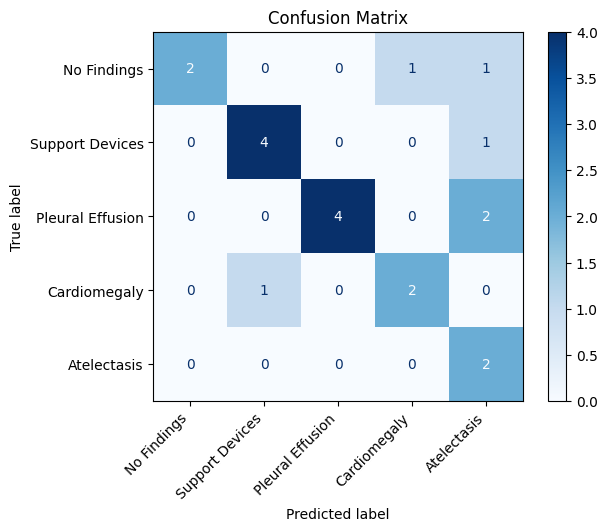

In [ ]:
from sklearn.metrics import classification_report


# Model parameters (adjust according to your model)
model_path = os.path.join(
    output_dir, "best_metric_model.pth"
)  # Path to your saved model
test_csv_path = (
    f"{csv_folder}/adaptor_tutorial_test_split.csv"  # Path to your test CSV file
)

# Prepare test data
test_df = pd.read_csv(test_csv_path)
test_merged = pd.merge(test_df, df_features, on="Name", how="inner")

test_samples = {
    "features": test_merged["features"].tolist(),
    "img_name": test_merged["Name"].tolist(),
}

# Create the DataLoader
test_ds = training.create_data_loader(
    test_samples,
    csv=test_merged,
    mode="test",
    batch_size=1,
    num_workers=2,
    pin_memory=True,
)

# Perform inference
model_inference = AdapterModel(in_channels, hidden_dim, num_class)
# Load the trained model
model_inference = inference.load_trained_model(model_inference, model_path)
predictions = inference.perform_inference(model_inference, test_ds)

# Extract ground truth labels from the image names in predictions
gtlabel_list = [
    test_df[test_df["Name"] == pred["Name"]]["Label"].values[0] for pred in predictions
]
gtlabel_category = [
    test_df[test_df["Name"] == pred["Name"]]["Label Category"].values[0]
    for pred in predictions
]
# Extract predicted labels from the predictions
pred_label_list = [pred["PredictedClass"] for pred in predictions]

# Generate classification report
report = classification_report(
    gtlabel_list,
    pred_label_list,
    target_names=[
        "No Findings",
        "Support Devices",
        "Pleural Effusion",
        "Cardiomegaly",
        "Atelectasis",
    ],
)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(gtlabel_list, pred_label_list)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[
        "No Findings",
        "Support Devices",
        "Pleural Effusion",
        "Cardiomegaly",
        "Atelectasis",
    ],
)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

**Key Insights:**

1. **Overall Accuracy:**
The model achieved an accuracy of 0.7500 (75%), meaning that 75% of the predictions made by the model were correct and demonstrating a significant improvement comparing with the zero-shot performance from the previous [notebook](./zero-shot-classification.ipynb). While this is a strong result, there is still room for improvement.

2. **Confusion Matrix Observations:**
- Most of the classes are classified correctly with most of the subjects, especially the unseen class Support Devices.
- However, the misclassified cases are always classified as Atelectasis

3. **Misclassification Trends:**
The most common misclassification occurred with the Atelectasis class, which was often predicted incorrectly for other classes, such as No Findings, Pleural Effusion, and Cardiomegaly. This suggests that the model might have difficulty distinguishing Atelectasis from other similar pathologies or normal cases.

**Recommendations for Next Steps:**
1. **Class-Specific Fine-Tuning:**
Given the frequent misclassification of other classes as Atelectasis, it may be beneficial to fine-tune the model on more specific examples of Atelectasis to improve its discrimination from other pathologies. Consider augmenting the dataset with more diverse and representative samples of Atelectasis.
2. **Further Model Fine-Tuning:**
Re-training the model with a focus on reducing misclassifications, particularly for Atelectasis and related classes, could improve performance. Consider using techniques such as class balancing or weighted loss functions to mitigate the effect of imbalanced data.

## 4. Visualizing Adapter Model Predictions and Comparison with Zero-Shot Classification
In this section, similar to the approach taken in the previous [notebook](./zero-shot-classification.ipynb), we visualize images to evaluate the quality of our adapter model. We use the same four subjects from the previous analysis and observe how the class predictions have changed for the misclassified subjects in the zero-shot classification approach.

**Key Insights from Visualizations**
1. Improvements in Predictions:
By applying the adapter model, we can observe how the model's predictions have improved over the zero-shot approach for some subjects. For instance, subjects that were previously misclassified in the zero-shot classification, such as those from the No Findings or Support Devices categories, now have more accurate predictions, reducing some of the model's earlier confusion.

2. Consistency with Prior Examples:
Using the same four subjects as in the zero-shot classification, we can compare the qualitative improvements or persisting errors between the two approaches. This direct comparison highlights the areas where the adapter model has successfully corrected previous mistakes and where further refinements are still needed.

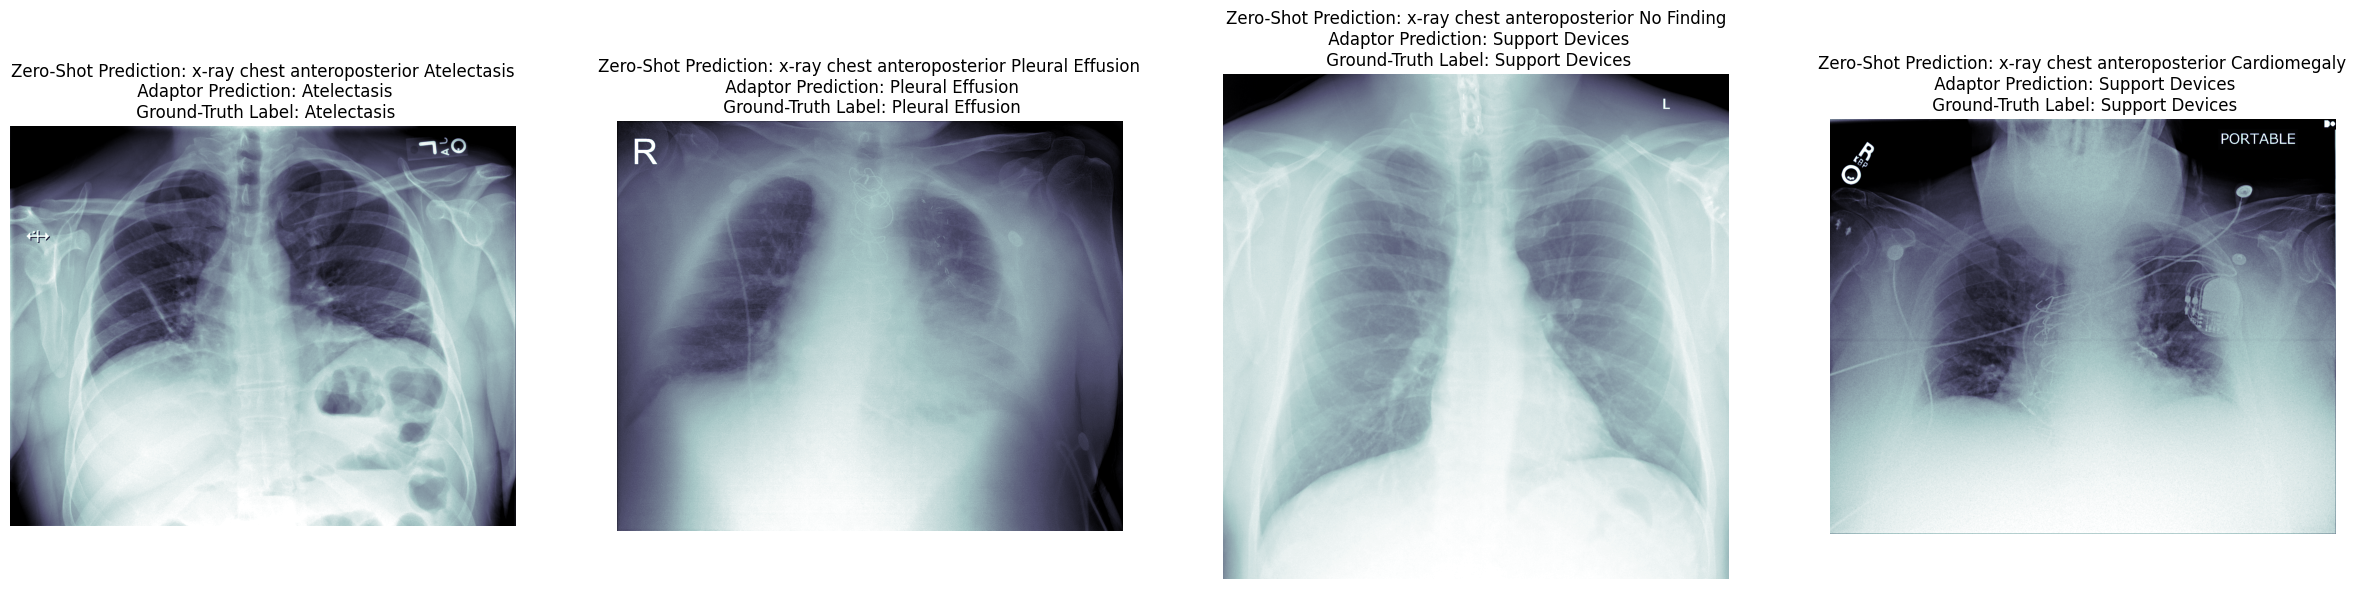

In [ ]:
## Organize and save the results for sample selection and visualization
label_category = [
    "No Findings",
    "Support Devices",
    "Pleural Effusion",
    "Cardiomegaly",
    "Atelectasis",
]

df = pd.DataFrame(
    {
        "file_name": [pred["Name"] for pred in predictions],
        "zero_shot_pred": [
            label_category[pred["PredictedClass"]] for pred in predictions
        ],
        "ground_truth_label": gtlabel_category,
    }
)
df.to_csv(
    "./adaptor_finetuning_classification_results.csv",
    index=False,
)

## Load Zero-Shot Classification Results
# You can also use your own results if you have done the zero shot classification notebook!
df_zero_shot = pd.read_csv(f"{csv_folder}/zero_shot_classification_results.csv")

# Select four images to visualize (Two correct examples and two failed examples)
selected_images = [
    "1.3.6.1.4.1.55648.013051327602219610100989737191708734008.2.1.green.dcm",
    "1.3.6.1.4.1.55648.045678110342520932233807899271374363433.1.1.green.dcm",
    "1.3.6.1.4.1.55648.255611619245397591591431066926543031128.1312.1.green.dcm",
    "1.3.6.1.4.1.55648.023647312006371870964474485493542161185.1.1.green.dcm",
]

selected_data = {
    image: {
        "selected_zero_shot_pred": df_zero_shot.loc[
            df_zero_shot["file_name"] == image, "zero_shot_pred"
        ].values[0],
        "selected_adaptor_pred": df.loc[
            df["file_name"] == image, "zero_shot_pred"
        ].values[0],
        "selected_ground_truth_labels": df.loc[
            df["file_name"] == image, "ground_truth_label"
        ].values[0],
    }
    for image in selected_images
}

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
for i, image_name in enumerate(selected_images):
    zeroshot_prediction = selected_data[image_name]["selected_zero_shot_pred"]
    adaptor_prediction = selected_data[image_name]["selected_adaptor_pred"]
    gt = selected_data[image_name]["selected_ground_truth_labels"]
    image_path = os.path.join(input_folder, image_name)
    image = mi2_client.read_and_normalize_image(image_path)
    axs[i].imshow(image, cmap="bone")
    axs[i].axis("off")
    axs[i].set_title(
        "Zero-Shot Prediction: {}\n Adaptor Prediction: {}\n Ground-Truth Label: {}".format(
            zeroshot_prediction, adaptor_prediction, gt
        )
    )

plt.show()

## 5. Final Remarks

The adapter training approach significantly improves upon the initial zero-shot classification, particularly in terms of accuracy and the ability to differentiate between various pathologies. In this particular example we observe potential for further refinement by improving the model's specificity when it comes to classifying Atelectasis. In case if this were the case in real world, the next steps to consider for achieving better generalization to real-world scenarios would be introducing data augmentation, improving dataset diversity, end eventually performing end-to-end fine-tuning.

## Next Steps

Having learned about the individual steps, you can explore the [MedImageInsights Fine-tuning](./finetuning/mi2-finetuning.ipynb) notebook for an example on how to fine-tune the underlying MedImageInsights model, and for details on how to run the fine-tuning and adapter training pipelines in AzureML, using pre-built pipeline components.